# **Datathon - Proyecto Individual 2**
## Daniel Vallejos

# **Estancia hospitalaria**
Un importante Centro de Salud lo ha contratado con el fin de poder predecir si un paciente tendrá una estancia hospitalaria prolongada o no, utilizando la información contenida en el dataset asociado, la cual recaba una muestra histórica de sus pacientes, para poder administrar la demanda de camas en el hospital según la condición de los pacientes recientemente ingresados.

Para esto, se define que un paciente posee estancia hospitalaria prolongada si ha estado hospitalizado más de 8 días. Por lo que debe generar dicha variable categórica y luego categorizar los pacientes según las variables que usted considere necesarias, justificando dicha elección.​

# **EDA - Análisis Exploratorio de los Datos**

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [45]:
#df_hos = pd.read_csv("drive/MyDrive/datasets/hospitaciones_train_m.csv")
#df_hos = pd.read_csv("./hospitalizaciones_train.csv")
df_hos = pd.read_csv("./datasets/hospitalizaciones_train.csv")

In [ ]:
#Cantidad de registros y columnas
df_hos.shape

In [ ]:
#Estructura del Dataframe
df_hos.info()

In [ ]:
df_hos.head()

In [ ]:
#Función para analizar diferentes aspectos de un dataframe a nivel de estructura y datos
def analyse_df(df, corr_limit = 0.75):
    """Analyse any dataframe and print results
    * Muestra cantidad de filas y columnas, cantidad de filas duplicadas, tamaño, tipos de datos
    * Chequea valores nulos
    * Chequea la correlación entre columnas. Por defecto: 0.75 para definir si existe relación
    """   

    print('Información General:')
    print(f'{df.shape[0]} Rows {df.shape[1]} Columnas'
          f'\n{df.duplicated().sum()} Filas duplicadas'
          f'\nTamaño: {df.memory_usage().sum()/(1024*1024):.2f}Mb')
    
    # Chequeando Data Types
    int_list, float_list,object_list,bool_list,other_list =[[] for i in range(5)]
    for col in df.columns:
        if df[col].dtype == 'int64':
            int_list.append(col)
        elif df[col].dtype == 'float64':
            float_list.append(col)
        elif df[col].dtype == 'object':
            object_list.append(col)
        elif df[col].dtype == 'boolean':
            bool_list.append(col)
        else:
            other_list.append(col)
            
    for type_list,data_type in zip([int_list, float_list,object_list,bool_list,other_list],
                                   ['int64','float64','object','boolean','other']):
        if len(type_list)>0:
            print(f'\nColumns {data_type}: {type_list}')
            
    # Info General
    display(df.describe())
    
    # Chequeando valores nulos
    print('\nChequeando valores nulos:')
    col_with_missing_counter = 0
    for col in df.columns:
        qnt_missing = df[col].isna().sum()
        if qnt_missing > 0:
            col_with_missing_counter +=1
            print(f'La columna "{col}" tiene {qnt_missing} nulos ({qnt_missing/df.shape[0]:.2%})')
    if col_with_missing_counter ==0 :
        print('El DataFrame no tiene nulos')
        
    # Chequeando la correlación lineal entre columnas
    print('\nChequeando la Correlation:')
    df_corr = df.corr() 
    ckecked_list =[] 
    cols_with_correlation_counter = 0
    for col in df_corr.columns:
        ckecked_list.append(col)
        for i in range(len(df_corr)):
            if ((df_corr[col][i] > corr_limit or df_corr[col][i] < -corr_limit) and
                (df_corr.index[i] not in ckecked_list)):
                cols_with_correlation_counter += 1
                print(f'Se encontró correlación entre las columnas '
                      f'{df_corr.index[i]} and {col} -> Pearson coef. = {df_corr[col][i]:.2f}')         
    if cols_with_correlation_counter == 0:
        print('No se encontró correlación')

In [ ]:
analyse_df(df_hos)

**Analizando las columnas**: las siguientes columnas se van a descartar


*   La columna: Ward_Facility_Code, número de habitación, no es representativa para este modelo, por sentido común.
*   La columna: Available Extra Rooms in Hospital, cantidad de habitaciones extras, no es representativa para este modelo.
*   La columna: staff_available, personal disponible, no es representativa para este modelo.
*   La columna: patientid, ID del paciente, no es representativa para este modelo por sentido común.
*   La columna: Visitors with Patient, cantidad de personas que visitaron al paciente, no es representativa para este modelo por sentido común, es un dato que se va alimentando con el paso del tiempo y no al ingreso.


In [ ]:
#df_hos.doctor_name.value_counts()
#df_hos.Age.value_counts()
#df_hos.gender.value_counts()
#df_hos['Type of Admission'].value_counts()
#df_hos['Severity of Illness'].value_counts()
#df_hos.health_conditions.value_counts()
#df_hos.Insurance.value_counts()
df_hos.Department.value_counts()

# **Transformación de Datos**
Se realiza adecuación de los datos para luego poder utilizarlos en el modelo

In [46]:
#Creo que la columna target: asigno valor 1 a todos los registros que tienen más de 8 en el el campo Stay (in days)
df_hos['EHP'] = df_hos['Stay (in days)'].apply(lambda x: 1 if x > 8 else 0 )

In [ ]:
df_hos.drop(columns=['age_0_10', 'age_11_20', 'age_21_30', 'age_31_40', 'age_41_50', 'age_51_60', 'age_61_70', 'age_71_80', 'age_81_90', 'age_91_100'], inplace=True)

In [47]:
from sklearn.preprocessing import OrdinalEncoder

In [48]:
#Creo una nueva columna para el rango de edades utilizando OrdinalEncoder
enc = OrdinalEncoder()
valores = df_hos.Age.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )

[array(['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70',
       '71-80', '81-90', '91-100'], dtype=object)]


In [49]:
df_hos['age_encoded'] = valores_endcoded[:,0]

In [62]:
enc = OneHotEncoder(sparse=False)
#valores = df_hos.Department.values.reshape(-1,1)
##valores = df_hos.doctor_name.values.reshape(-1,1)
#valores = df_hos.gender.values.reshape(-1,1)
#valores = df_hos['Type of Admission'].values.reshape(-1,1)
#valores = df_hos['Severity of Illness'].values.reshape(-1,1)
#valores = df_hos.health_conditions.values.reshape(-1,1)
valores = df_hos.Insurance.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )

[array(['No', 'Yes'], dtype=object)]


In [63]:
df_hos['ins_no'] = valores_endcoded[:,0]
df_hos['ins_yes'] = valores_endcoded[:,1]

In [61]:
df_hos['hcon_Asthama'] = valores_endcoded[:,0]
df_hos['hcon_Diabetes'] = valores_endcoded[:,1]
df_hos['hcon_Heart_disease'] = valores_endcoded[:,2]
df_hos['hcon_High_Blood_Pressure'] = valores_endcoded[:,3]
df_hos['hcon_None'] = valores_endcoded[:,4]
df_hos['hcon_Other'] = valores_endcoded[:,5]

In [59]:
df_hos['sev_Extreme'] = valores_endcoded[:,0]
df_hos['sev_Minor'] = valores_endcoded[:,1]
df_hos['sev_Moderate'] = valores_endcoded[:,2]

In [57]:
df_hos['type_Emergency'] = valores_endcoded[:,0]
df_hos['type_Trauma'] = valores_endcoded[:,1]
df_hos['type_Urgent'] = valores_endcoded[:,2]

In [55]:
df_hos['gen_male'] = valores_endcoded[:,0]
df_hos['gen_female'] = valores_endcoded[:,1]
df_hos['gen_other'] = valores_endcoded[:,2]

In [53]:
df_hos['dep_TB&Chest'] = valores_endcoded[:,0]
df_hos['dep_anesthesia'] = valores_endcoded[:,1]
df_hos['dep_gynecology'] = valores_endcoded[:,2]
df_hos['dep_radiotherapy'] = valores_endcoded[:,3]
df_hos['dep_surgery'] = valores_endcoded[:,4]

In [ ]:
df_hos['dn_Isaac'] = valores_endcoded[:,0]
df_hos['dn_John'] = valores_endcoded[:,1]
df_hos['dn_Mark'] = valores_endcoded[:,2]
df_hos['dn_Nathan'] = valores_endcoded[:,3]
df_hos['dn_Olivia'] = valores_endcoded[:,4]
df_hos['dn_Sam'] = valores_endcoded[:,5]
df_hos['dn_Sarah'] = valores_endcoded[:,6]
df_hos['dn_Simon'] = valores_endcoded[:,7]
df_hos['dn_Sophia'] = valores_endcoded[:,8]

In [ ]:
df_hos.columns

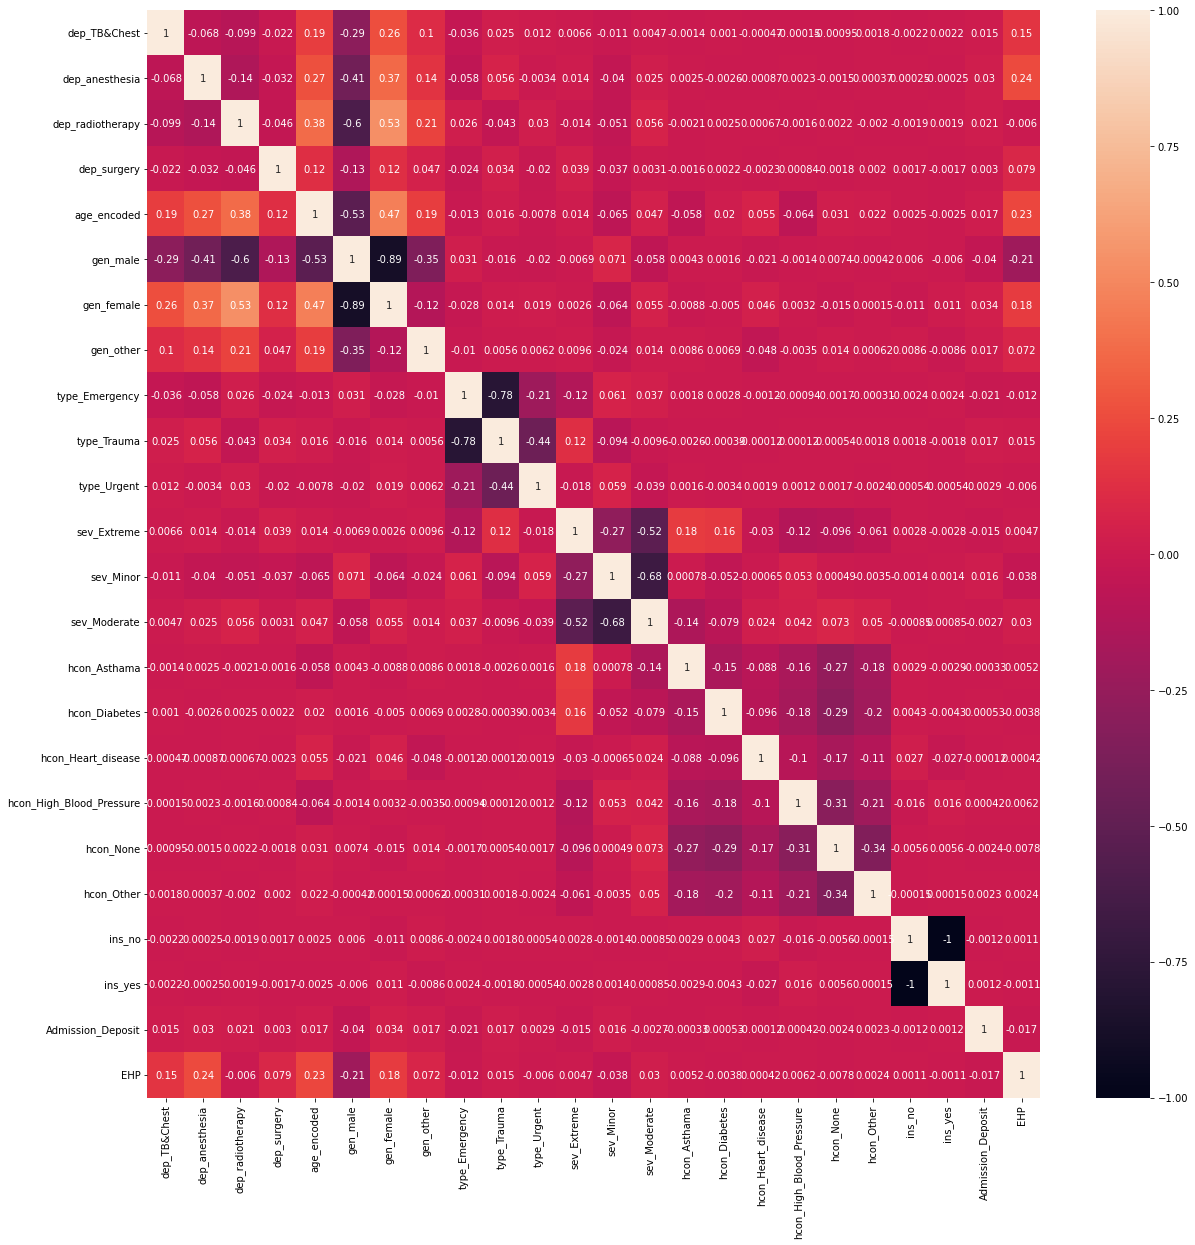

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
corr = df_x2.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        ax=ax);

In [ ]:
df_ss = df_hos.sample(frac=0.1, replace=True, random_state=1)

In [ ]:
df_hos = df_ss.copy()

In [ ]:
df_ho

In [64]:
df_hos.shape

(410000, 39)

In [ ]:
df_hos.head()

,Unnamed: 0,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,...,sev_Minor,sev_Moderate,hcon_Asthama,hcon_Diabetes,hcon_Heart_disease,hcon_High_Blood_Pressure,hcon_None,hcon_Other,ins_no,ins_yes
0,0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
df_x2 = df_hos[[
    'dep_TB&Chest', 'dep_anesthesia', 'dep_radiotherapy', 'dep_surgery',
    'age_encoded',
    'gen_male', 'gen_female', 'gen_other',
    'type_Emergency', 'type_Trauma', 'type_Urgent',
    'sev_Extreme', 'sev_Minor', 'sev_Moderate',
    'hcon_Asthama', 'hcon_Diabetes', 'hcon_Heart_disease', 'hcon_High_Blood_Pressure', 'hcon_None', 'hcon_Other',
    'ins_no', 'ins_yes',
    'Available Extra Rooms in Hospital','staff_available',
    'Admission_Deposit',
    'EHP']]

#    'Admission_Deposit',
#    'dep_TB&Chest', 'dep_anesthesia', 'dep_gynecology', 'dep_radiotherapy', 'dep_surgery',
#    'age_0_10', 'age_11_20', 'age_21_30', 'age_31_40', 'age_41_50', 'age_51_60', 'age_61_70', 'age_71_80', 'age_81_90', 'age_91_100',


In [ ]:
#df_x2 = df_hos[['dep_anesthesia', 'dep_surgery', 'age_encoded','gen_male','gen_female','gen_other','EHP']]

# **Corriendo Modelos de ML**
Se divide el set de datos en entrenamiento y test (20%)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [66]:
#Defino la columnas para las variables independientes y dependiente
X = df_x2.drop(['EHP'], axis = 1 )
y = df_hos['EHP']

In [67]:
#Split test del 20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [68]:
#Standarizo los valores usando StandardScaler
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

## Modelo: Arbol de Decisión

In [69]:
clf = DecisionTreeClassifier(max_depth = 9, random_state = 42)

In [70]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=42)

In [71]:
print("Accuracy on training set: {:.3f}".format(clf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(x_test, y_test)))

Accuracy on training set: 0.712
Accuracy on test set: 0.712


In [72]:
y_pred = clf.predict(x_test)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.40      0.51     31078
           1       0.71      0.90      0.80     50922

    accuracy                           0.71     82000
   macro avg       0.71      0.65      0.65     82000
weighted avg       0.71      0.71      0.69     82000



## Modelo Gradient Boosting

In [74]:
gb = GradientBoostingClassifier(random_state=0)
gb.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(gb.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(x_test, y_test)))

Accuracy on training set: 0.718
Accuracy on test set: 0.717


In [75]:
y_pred = gb.predict(x_test)

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.44      0.54     31078
           1       0.72      0.89      0.80     50922

    accuracy                           0.72     82000
   macro avg       0.71      0.66      0.67     82000
weighted avg       0.71      0.72      0.70     82000



In [77]:
accuracy_score(y_test, y_pred)

0.7172804878048781

In [78]:
recall_score(y_test, y_pred, average= None)

array([0.43867044, 0.88731786])

## Modelo Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.729


In [ ]:
y_pred = rf.predict(x_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.7288658536585366
[0.6326702  0.78722862]
              precision    recall  f1-score   support

           0       0.64      0.63      0.64     30964
           1       0.78      0.79      0.78     51036

    accuracy                           0.73     82000
   macro avg       0.71      0.71      0.71     82000
weighted avg       0.73      0.73      0.73     82000



## Modelo SVC

In [ ]:
clf = SVC(kernel='poly', random_state=0)
clf.fit(x_train, y_train)

SVC(kernel='poly', random_state=0)

In [ ]:
print("Accuracy on training set: {:.3f}".format(clf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(x_test, y_test)))

Accuracy on training set: 0.696
Accuracy on test set: 0.683


In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.6826829268292683
[0.24674055 0.94329696]
              precision    recall  f1-score   support

           0       0.72      0.25      0.37      3068
           1       0.68      0.94      0.79      5132

    accuracy                           0.68      8200
   macro avg       0.70      0.60      0.58      8200
weighted avg       0.69      0.68      0.63      8200



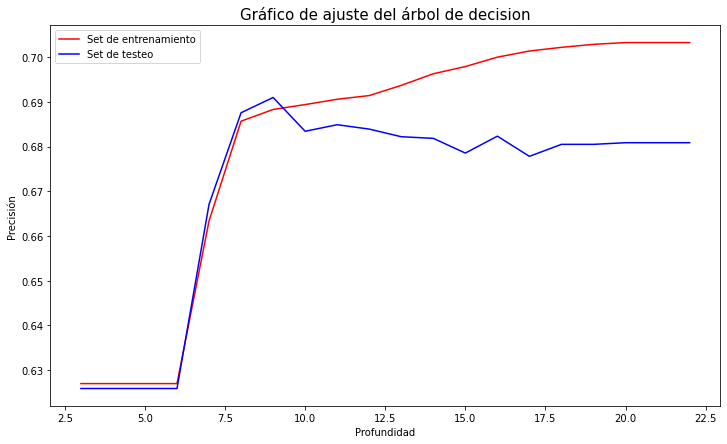

In [ ]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(3, 23))

for deep in max_deep_list:
    clf_3 = DecisionTreeClassifier(max_depth=deep, criterion='entropy')
    clf_3.fit(x_train, y_train)
    train_prec.append(clf_3.score(x_train, y_train))
    eval_prec.append(clf_3.score(x_test, y_test))

plt.figure(figsize=(12,7))
plt.plot(max_deep_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.ylabel('Precisión')
plt.xlabel('Profundidad')
plt.show()

## Modelo Regresión Logística

In [ ]:
log_clf = LogisticRegression()

In [ ]:
log_clf.fit(x_train, y_train)

LogisticRegression()

In [ ]:
y_pred = log_clf.predict(x_test)

In [ ]:
print("Accuracy on training set: {:.3f}".format(log_clf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(log_clf.score(x_test, y_test)))

Accuracy on training set: 0.590
Accuracy on test set: 0.589


In [ ]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.5893048780487805
[0.26588942 0.78552394]
              precision    recall  f1-score   support

           0       0.43      0.27      0.33     30964
           1       0.64      0.79      0.70     51036

    accuracy                           0.59     82000
   macro avg       0.53      0.53      0.52     82000
weighted avg       0.56      0.59      0.56     82000



In [ ]:
from sklearn.feature_selection import f_regression 

In [ ]:
x = df_x2[df_x2.columns[1:].tolist()]
f_stats_values = f_regression(x,y)[0]
p_values = f_regression(x,y)[1] #para obter somente os p_values

f_regression_df = pd.DataFrame({'Feature':df_x2.columns[1:].tolist(),
                                'f_statistic' : f_stats_values,
                                'p_values':p_values
                               })

f_regression_df

,Feature,f_statistic,p_values
0,dep_anesthesia,2.556803e+04,0.000000e+00
1,dep_radiotherapy,1.452948e+01,1.380038e-04
2,dep_surgery,2.557846e+03,0.000000e+00
3,age_encoded,2.282822e+04,0.000000e+00
4,gen_male,1.835285e+04,0.000000e+00
5,gen_female,1.441990e+04,0.000000e+00
6,gen_other,2.153401e+03,0.000000e+00
7,type_Emergency,6.376949e+01,1.402211e-15
8,type_Trauma,9.536239e+01,1.594370e-22
9,type_Urgent,1.467234e+01,1.279286e-04


## Modelo XGBoost

In [ ]:
#from xgboost import XGBClassifier

In [79]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier()

In [80]:
y_pred = model.predict(x_test)

In [81]:
print("Accuracy on training set: {:.3f}".format(model.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(x_test, y_test)))

Accuracy on training set: 0.712
Accuracy on test set: 0.710


In [82]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.7096707317073171
[0.41576034 0.88904599]
              precision    recall  f1-score   support

           0       0.70      0.42      0.52     31078
           1       0.71      0.89      0.79     50922

    accuracy                           0.71     82000
   macro avg       0.70      0.65      0.66     82000
weighted avg       0.71      0.71      0.69     82000



In [83]:
y_pred_tran = y_pred

In [85]:
y_pred_tran

array([1, 1, 1, ..., 1, 1, 1])

## Ajusto dataset de test con los cambios

In [86]:
df_hos_t = pd.read_csv("./datasets/hospitalizaciones_test.csv")

In [88]:
enc = OrdinalEncoder()
valores = df_hos_t.Age.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )

[array(['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70',
       '71-80', '81-90', '91-100'], dtype=object)]


In [89]:
df_hos_t['age_encoded'] = valores_endcoded[:,0]

In [92]:
enc = OneHotEncoder(sparse=False)
valores = df_hos_t.Department.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )
df_hos_t['dep_TB&Chest'] = valores_endcoded[:,0]
df_hos_t['dep_anesthesia'] = valores_endcoded[:,1]
df_hos_t['dep_gynecology'] = valores_endcoded[:,2]
df_hos_t['dep_radiotherapy'] = valores_endcoded[:,3]
df_hos_t['dep_surgery'] = valores_endcoded[:,4]

[array(['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy',
       'surgery'], dtype=object)]


In [93]:
enc = OneHotEncoder(sparse=False)
valores = df_hos_t.gender.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )
df_hos_t['gen_male'] = valores_endcoded[:,0]
df_hos_t['gen_female'] = valores_endcoded[:,1]
df_hos_t['gen_other'] = valores_endcoded[:,2]

[array(['Female', 'Male', 'Other'], dtype=object)]


In [94]:
enc = OneHotEncoder(sparse=False)
valores = df_hos_t['Type of Admission'].values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )
df_hos_t['type_Emergency'] = valores_endcoded[:,0]
df_hos_t['type_Trauma'] = valores_endcoded[:,1]
df_hos_t['type_Urgent'] = valores_endcoded[:,2]

[array(['Emergency', 'Trauma', 'Urgent'], dtype=object)]


In [95]:
enc = OneHotEncoder(sparse=False)
valores = df_hos_t['Severity of Illness'].values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )
df_hos_t['sev_Extreme'] = valores_endcoded[:,0]
df_hos_t['sev_Minor'] = valores_endcoded[:,1]
df_hos_t['sev_Moderate'] = valores_endcoded[:,2]

[array(['Extreme', 'Minor', 'Moderate'], dtype=object)]


In [96]:
enc = OneHotEncoder(sparse=False)
valores = df_hos_t.health_conditions.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )
df_hos_t['hcon_Asthama'] = valores_endcoded[:,0]
df_hos_t['hcon_Diabetes'] = valores_endcoded[:,1]
df_hos_t['hcon_Heart_disease'] = valores_endcoded[:,2]
df_hos_t['hcon_High_Blood_Pressure'] = valores_endcoded[:,3]
df_hos_t['hcon_None'] = valores_endcoded[:,4]
df_hos_t['hcon_Other'] = valores_endcoded[:,5]

[array(['Asthama', 'Diabetes', 'Heart disease', 'High Blood Pressure',
       'None', 'Other'], dtype=object)]


In [97]:
enc = OneHotEncoder(sparse=False)
valores = df_hos_t.Insurance.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )
df_hos_t['ins_no'] = valores_endcoded[:,0]
df_hos_t['ins_yes'] = valores_endcoded[:,1]

[array(['No', 'Yes'], dtype=object)]


In [98]:
df_x2_t = df_hos_t[[
    'dep_TB&Chest', 'dep_anesthesia', 'dep_radiotherapy', 'dep_surgery',
    'age_encoded',
    'gen_male', 'gen_female', 'gen_other',
    'type_Emergency', 'type_Trauma', 'type_Urgent',
    'sev_Extreme', 'sev_Minor', 'sev_Moderate',
    'hcon_Asthama', 'hcon_Diabetes', 'hcon_Heart_disease', 'hcon_High_Blood_Pressure', 'hcon_None', 'hcon_Other',
    'ins_no', 'ins_yes',
    'Available Extra Rooms in Hospital','staff_available',
    'Admission_Deposit',
    ]]

In [102]:
y_pred_test = model.predict(df_x2_t.values)

In [103]:
df_pred = pd.DataFrame()
df_pred['pred'] = y_pred_test

In [104]:
df_pred.to_csv('./odvallejos.csv', index=False)

In [100]:
df_x2_t.columns

Index(['dep_TB&Chest', 'dep_anesthesia', 'dep_radiotherapy', 'dep_surgery',
       'age_encoded', 'gen_male', 'gen_female', 'gen_other', 'type_Emergency',
       'type_Trauma', 'type_Urgent', 'sev_Extreme', 'sev_Minor',
       'sev_Moderate', 'hcon_Asthama', 'hcon_Diabetes', 'hcon_Heart_disease',
       'hcon_High_Blood_Pressure', 'hcon_None', 'hcon_Other', 'ins_no',
       'ins_yes', 'Available Extra Rooms in Hospital', 'staff_available',
       'Admission_Deposit'],
      dtype='object')

In [101]:
df_x2.columns

Index(['dep_TB&Chest', 'dep_anesthesia', 'dep_radiotherapy', 'dep_surgery',
       'age_encoded', 'gen_male', 'gen_female', 'gen_other', 'type_Emergency',
       'type_Trauma', 'type_Urgent', 'sev_Extreme', 'sev_Minor',
       'sev_Moderate', 'hcon_Asthama', 'hcon_Diabetes', 'hcon_Heart_disease',
       'hcon_High_Blood_Pressure', 'hcon_None', 'hcon_Other', 'ins_no',
       'ins_yes', 'Available Extra Rooms in Hospital', 'staff_available',
       'Admission_Deposit', 'EHP'],
      dtype='object')